### Example notebook for a general script to run aging cycle

In [57]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import csv, random, os,sys
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl; 
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
########################     Global settings!!!
rows_per_file = 4;  Scan_end_end = 1000;
purpose_i = "Sweep_Sol_Age_2"

On_HPC = False 
Runshort = True                    # a long run or a quick test

if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 3; # manually specify # 30

Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters

In [59]:
# specify path:
if On_HPC:                          # Run on HPC
    Path_Data_pre = "InputData/" 
    BasicPath=os.getcwd() 
    Para_file = f"InputData/{purpose_i}/"  +  para_csv
else:
    Path_Data_pre = os.path.expanduser(
        "~/EnvPB_Linux/PyBaMM/scripts/HPC_Li_et_al/HPC_Paper_SimSave/Example_Expdata") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPB_Linux/PyBaMM/scripts/HPC_Li_et_al/HPC_Paper_SimSave/Results")
    Para_file = os.path.expanduser(
        "~/EnvPB_Linux/PyBaMM/scripts/HPC_Li_et_al/HPC_Paper_SimSave")+f'/Get_Input/{purpose_i}/'+para_csv

if not os.path.exists(BasicPath +"/"+ purpose):
    os.mkdir(BasicPath +"/"+ purpose);

from scripts.HPC_Li_et_al.ParaSweeper.Fun_HPC import *
parameter_names, combinations = load_combinations_from_csv(Para_file)

In [60]:
pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1

# Get all para
Para_dict_list = []
# get all dictionaries
for combination in combinations:
    input_dict = {}
    for parameter_name,para_value in zip(parameter_names,combination ):
        input_dict[parameter_name] = para_value
    Para_dict_list.append(input_dict)
print(f"Total scan case is {len(Para_dict_list)}")

# try to plot experiment data
Path_Data  = Path_Data_pre+"/example_Age_SOH.csv"
my_data = pd.read_csv( Path_Data)

cap_thr   = my_data["Charge Throughput (A.h)"] / 1e3
cap_C_10  = my_data["C/10 Capacity (mA.h)"]/1e3
soh_C_10  = cap_C_10 / cap_C_10[0] * 100
# plt.plot(cap_thr,soh_C_10,"-o")
cap_thr   = np.array(cap_thr).tolist()
cap_C_10  = np.array(cap_C_10).tolist()
soh_C_10  = np.array(soh_C_10).tolist()
XY_Exp =[cap_thr,soh_C_10]

#####################################################################
########################  Define experiment  ########################
#####################################################################
V_max = 4.2;        V_min = 2.5; 
exp_AGE_text = [(
    f"Discharge at 1C until {V_min}V", 
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max} V until C/100",
    ),  ]  # *  78
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;
exp_RPT_text = [ (
    # refill
    "Rest for 1 minutes", # change this step to rest to avoid errors. 
    "Rest for 1 hours", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours",
    ) ] * 1
exp_breakin_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours",
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
cycle_no = -1; 

Total scan case is 4


In [61]:
Para_dict_list[0]

{'Scan No': 9,
 'Ageing temperature': 10.0,
 'Outer SEI solvent diffusivity [m2.s-1]': 1e-22,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Negative electrode LAM constant proportional term [s-1]': 5e-10,
 'Negative electrode cracking rate': 1e-22,
 'Total ageing cycles': 1170,
 'Ageing cycles between RPT': 78,
 'Update cycles for ageing': 26,
 'Initial electrolyte excessive amount ratio': 1.0,
 'Cycles within RPT': 1,
 'RPT temperature': 25,
 'Mesh list': '[5,5,5,60,20]',
 'Para_Set': 'OKane2022',
 'Model option': "{'thermal': 'lumped', 'SEI': 'solvent-diffusion limited', 'SEI on cracks': 'true', 'SEI film resistance': 'distributed', 'SEI porosity change': 'true', 'particle mechanics': ('swelling and cracking', 'swelling only'), 'loss of active material': ('stress-driven', 'none'), 'lithium plating': 'partially reversible'}",
 'Current solvent concentration in the reservoir [mol.m-3]': 4541.0,
 'Current electrolyte concentration in the reservoir [mol.m-3]': 1000,
 'Ratio of Li-ion co

In [62]:
#####################################################################
########################  Output  ###################################
#####################################################################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];

# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Y or N",
    "Error %","Punish",
    "Dry out",]
head_pos = [ 
   "exp_AGE_text", "exp_RPT_text",
   "SOH [%]","LLI [%]","LLI to LiP [%]",
   "LLI to SEI [%]","LLI to sei-on-cracks [%]",
   "LLI due to LAM [%]","LAM_to_Crack_NE [%]","LAM_to_Crack_PE [%]",
   "LAM_to_Dry [%]","Error"]

Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
if not os.path.exists(BasicPath +Target):
    os.mkdir(BasicPath +Target);
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack =[
    exp_AGE_text,exp_RPT_text,exp_breakin_text,
    step_AGE_CD,step_AGE_CC,step_AGE_CV,
    step_0p1C_CD ,step_0p1C_CC,step_0p1C_RE,
    cycle_no,book_name_xlsx,
    ] 
if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [63]:
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  flag_RunOneCyc = False
Return_Sol=True;   Check_Small_Time=True;
fs = 13; dpi = 100;

midc_merge,Sol_RPT,Sol_AGE,Call_Age= Run_model (
    Para_dict_list[0],BasicPath, XY_Exp, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
    Check_Small_Time
) 

""" if __name__ == "__main__":
    pool = multiprocessing.Pool(int(pool_no))
    processes = [
    pool.apply_async(
        Run_model, 
        args=(
            Para_dict_i,BasicPath, XY_Exp, 
            purpose,    Exp_pack, keys_all,dpi,fs,
            flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
            Check_Small_Time
        ) )
        for Para_dict_i in Para_dict_list]
    Result = [p.get() for p in processes]  

for result in Result:
    midc_merge_all.append(result[0])
    Sol_RPT_all.append(result[1])
    Sol_AGE_all.append(result[2]) 
"""

Your own print statement
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 9.
Start Now! Scan 9.
Start Now! Scan 9.
Start Now! Scan 9.
Start Now! Scan 9.
Start Now! Scan 9.
Start Now! Scan 9.
Scan 9: DryOut = On
Scan 9: DryOut = On
Scan 9: DryOut = On
Scan 9: DryOut = On
Scan 9: DryOut = On
Scan 9: DryOut = On
Scan 9: DryOut = On
Scan 9: Spent 33.857 ms on Initialization
Scan 9: Spent 33.857 ms on Initialization
Scan 9: Spent 33.857 ms on Initialization
Scan 9: Spent 33.857 ms on Initialization
Scan 9: Spent 33.857 ms on Initialization
Scan 9: Spent 33.857 ms on Initialization
Scan 9: Spent 33.857 ms on Initialization


Initial electrolyte amount is  5.1261558457200005 mL


Scan 9: Finish break-in cycle within 33.715 s
Scan 9: Finish break-in cycle within 33.715 s
Scan 9: Finish break-in cycle within 33.715 s
Scan 9: Finish break-in cycle within 33.715 s
Scan 9: Finish break-in cycle within 33.715 s
Scan 9: Finish break-in cycle within 33.715 s
Scan 9: Finish break-in cycle within 33.715 s
Scan 9: Finish post-process for break-in cycle within 1.101 s
Scan 9: Finish post-process for break-in cycle within 1.101 s
Scan 9: Finish post-process for break-in cycle within 1.101 s
Scan 9: Finish post-process for break-in cycle within 1.101 s
Scan 9: Finish post-process for break-in cycle within 1.101 s
Scan 9: Finish post-process for break-in cycle within 1.101 s
Scan 9: Finish post-process for break-in cycle within 1.101 s
At t = 317.353 and h = 5.01829e-11, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 9: Finish for No.0 ageing cycles within 12.026 s
Scan 9: Finish for No.0 ageing cycles within 12.026 s
Scan 9: Finish for No.0 ageing cycle

Succeed to run the ageing set for 1 cycles the 1th time


Scan 9: Finish post-process for No.1 ageing cycles within 330.919 ms
Scan 9: Finish post-process for No.1 ageing cycles within 330.919 ms
Scan 9: Finish post-process for No.1 ageing cycles within 330.919 ms
Scan 9: Finish post-process for No.1 ageing cycles within 330.919 ms
Scan 9: Finish post-process for No.1 ageing cycles within 330.919 ms
Scan 9: Finish post-process for No.1 ageing cycles within 330.919 ms
Scan 9: Finish post-process for No.1 ageing cycles within 330.919 ms


Electrolyte is being squeezed out, check plated lithium (active and dead)


Scan 9: Finish for No.1 RPT cycles within 34.446 s
Scan 9: Finish for No.1 RPT cycles within 34.446 s
Scan 9: Finish for No.1 RPT cycles within 34.446 s
Scan 9: Finish for No.1 RPT cycles within 34.446 s
Scan 9: Finish for No.1 RPT cycles within 34.446 s
Scan 9: Finish for No.1 RPT cycles within 34.446 s
Scan 9: Finish for No.1 RPT cycles within 34.446 s


Succeed to run RPT for the 1th time


Scan 9: Finish post-process for No.1 RPT cycles within 790.166 ms
Scan 9: Finish post-process for No.1 RPT cycles within 790.166 ms
Scan 9: Finish post-process for No.1 RPT cycles within 790.166 ms
Scan 9: Finish post-process for No.1 RPT cycles within 790.166 ms
Scan 9: Finish post-process for No.1 RPT cycles within 790.166 ms
Scan 9: Finish post-process for No.1 RPT cycles within 790.166 ms
Scan 9: Finish post-process for No.1 RPT cycles within 790.166 ms
At t = 315.675 and h = 2.69209e-12, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 9: Finish for No.1 ageing cycles within 12.553 s
Scan 9: Finish for No.1 ageing cycles within 12.553 s
Scan 9: Finish for No.1 ageing cycles within 12.553 s
Scan 9: Finish for No.1 ageing cycles within 12.553 s
Scan 9: Finish for No.1 ageing cycles within 12.553 s
Scan 9: Finish for No.1 ageing cycles within 12.553 s
Scan 9: Finish for No.1 ageing cycles within 12.553 s


Succeed to run the ageing set for 1 cycles the 1th time


Scan 9: Finish post-process for No.2 ageing cycles within 269.105 ms
Scan 9: Finish post-process for No.2 ageing cycles within 269.105 ms
Scan 9: Finish post-process for No.2 ageing cycles within 269.105 ms
Scan 9: Finish post-process for No.2 ageing cycles within 269.105 ms
Scan 9: Finish post-process for No.2 ageing cycles within 269.105 ms
Scan 9: Finish post-process for No.2 ageing cycles within 269.105 ms
Scan 9: Finish post-process for No.2 ageing cycles within 269.105 ms


Electrolyte is being squeezed out, check plated lithium (active and dead)


Scan 9: Finish for No.2 RPT cycles within 38.258 s
Scan 9: Finish for No.2 RPT cycles within 38.258 s
Scan 9: Finish for No.2 RPT cycles within 38.258 s
Scan 9: Finish for No.2 RPT cycles within 38.258 s
Scan 9: Finish for No.2 RPT cycles within 38.258 s
Scan 9: Finish for No.2 RPT cycles within 38.258 s
Scan 9: Finish for No.2 RPT cycles within 38.258 s


Succeed to run RPT for the 1th time


Scan 9: Finish post-process for No.2 RPT cycles within 800.956 ms
Scan 9: Finish post-process for No.2 RPT cycles within 800.956 ms
Scan 9: Finish post-process for No.2 RPT cycles within 800.956 ms
Scan 9: Finish post-process for No.2 RPT cycles within 800.956 ms
Scan 9: Finish post-process for No.2 RPT cycles within 800.956 ms
Scan 9: Finish post-process for No.2 RPT cycles within 800.956 ms
Scan 9: Finish post-process for No.2 RPT cycles within 800.956 ms
Scan 9: Getting extra variables within 313.200 us
Scan 9: Getting extra variables within 313.200 us
Scan 9: Getting extra variables within 313.200 us
Scan 9: Getting extra variables within 313.200 us
Scan 9: Getting extra variables within 313.200 us
Scan 9: Getting extra variables within 313.200 us
Scan 9: Getting extra variables within 313.200 us
Scan 9: Finish all plots within 4.684 s
Scan 9: Finish all plots within 4.684 s
Scan 9: Finish all plots within 4.684 s
Scan 9: Finish all plots within 4.684 s
Scan 9: Finish all plots wit

Successfully create a excel file


' if __name__ == "__main__":\n    pool = multiprocessing.Pool(int(pool_no))\n    processes = [\n    pool.apply_async(\n        Run_model, \n        args=(\n            Para_dict_i,BasicPath, XY_Exp, \n            purpose,    Exp_pack, keys_all,dpi,fs,\n            flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,\n            Check_Small_Time\n        ) )\n        for Para_dict_i in Para_dict_list]\n    Result = [p.get() for p in processes]  \n\nfor result in Result:\n    midc_merge_all.append(result[0])\n    Sol_RPT_all.append(result[1])\n    Sol_AGE_all.append(result[2]) \n'

In [64]:
# Write summary into excel
Index_List_succeed = index_list
for k,index_i in enumerate(Index_List_succeed):
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = table_tar.max_row # ncolumns_old + k +1 # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 



Successfuly write results for Scan 9!
Something goes wrong for Scan 10!
Something goes wrong for Scan 11!
Something goes wrong for Scan 12!


In [65]:
midc_merge["CDend Loss of capacity to SEI on cracks [A.h]"]
def Get_Model_DMA(my_dict_RPT):
    my_dict_RPT["CDend LAM_ne [%]"] = ((1-
            np.array(my_dict_RPT['CDend Negative electrode capacity [A.h]'])
            /my_dict_RPT['CDend Negative electrode capacity [A.h]'][0])*100).tolist()
    my_dict_RPT["CDend LAM_pe [%]"] = ((1-
        np.array(my_dict_RPT['CDend Positive electrode capacity [A.h]'])
        /my_dict_RPT['CDend Positive electrode capacity [A.h]'][0])*100).tolist()
    my_dict_RPT["CDend LLI [%]"] = ((1-
        np.array(my_dict_RPT["CDend Total lithium capacity in particles [A.h]"])
        /my_dict_RPT["CDend Total lithium capacity in particles [A.h]"][0])*100).tolist()

    my_dict_RPT["CDend LLI SEI [%]"] = ((
        np.array(
            my_dict_RPT["CDend Loss of capacity to SEI [A.h]"]-
            my_dict_RPT["CDend Loss of capacity to SEI [A.h]"][0]
            )
        /my_dict_RPT["CDend Total lithium capacity in particles [A.h]"][0])*100).tolist()

    my_dict_RPT["CDend LLI SEI on cracks [%]"] = ((
        np.array(
            my_dict_RPT["CDend Loss of capacity to SEI on cracks [A.h]"]-
            my_dict_RPT["CDend Loss of capacity to SEI on cracks [A.h]"][0]
            )
        /my_dict_RPT["CDend Total lithium capacity in particles [A.h]"][0])*100).tolist()

    my_dict_RPT["CDend LLI lithium plating [%]"] = ((
        np.array(
            my_dict_RPT["CDend Loss of capacity to lithium plating [A.h]"]-
            my_dict_RPT["CDend Loss of capacity to lithium plating [A.h]"][0]
            )
        /my_dict_RPT["CDend Total lithium capacity in particles [A.h]"][0])*100).tolist()
    my_dict_RPT["CDend LLI due to LAM [%]"] = (
        np.array(my_dict_RPT['CDend LLI [%]'])
        -my_dict_RPT["CDend LLI SEI [%]"]
        -my_dict_RPT["CDend LLI lithium plating [%]"]
        -my_dict_RPT["CDend LLI SEI on cracks [%]"] )
    return my_dict_RPT
midc_merge = Get_Model_DMA(midc_merge)

In [66]:
LAM_to_Dry   = 100-np.array(
    midc_merge['Width_all']) /midc_merge['Width_all'][0]*100

LAM_to_Dry_i=LAM_to_Dry[-1]
LAM_to_Crack_NE_i=midc_merge['CDend LAM_ne [%]'][-1]-LAM_to_Dry_i
LAM_to_Crack_PE_i=midc_merge['CDend LAM_pe [%]'][-1]-LAM_to_Dry_i
print(LAM_to_Dry_i,LAM_to_Crack_NE_i,LAM_to_Crack_PE_i)

0.12080038717930108 8.59486892501593e-06 4.1744385725905886e-14


Text(0, 0.5, 'LLI %')

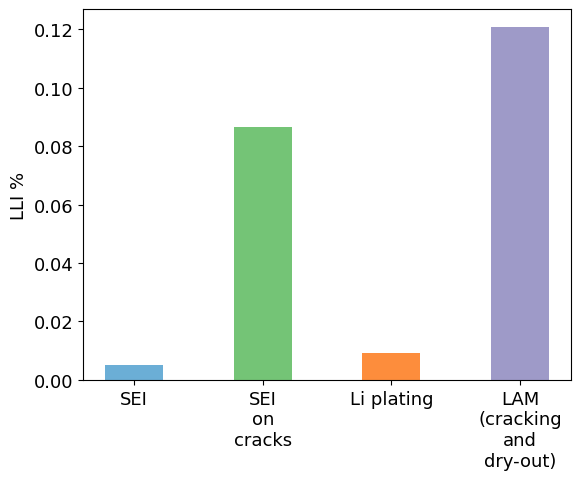

In [67]:
# DMA component:
fig, ax = plt.subplots(figsize=(6,5),tight_layout=True) 
# "SEI":               midc_merge["CDend LLI SEI [%]"]
# "SEI on cracks":     midc_merge["CDend LLI SEI on cracks [%]"]
# "Li plating":        midc_merge["CDend LLI lithium plating [%]"] 
# "LAM":               midc_merge["CDend LLI due to LAM [%]"]
def adjust_category_names(categories):
    return ['\n'.join(category.split()) if len(category) > 12 else category for category in categories]

categories = ['SEI', 'SEI on cracks', 'Li plating', 'LAM (cracking and dry-out)']
adjusted_categories = adjust_category_names(categories)
colors = ['#6baed6', '#74c476', '#fd8d3c', '#9e9ac8']
values = [
    midc_merge["CDend LLI SEI [%]"][-1], 
    midc_merge["CDend LLI SEI on cracks [%]"][-1], 
    midc_merge["CDend LLI lithium plating [%]"][-1] , 
    midc_merge["CDend LLI due to LAM [%]"][-1]   ]

# Creating the bar plot
plt.bar(adjusted_categories, values, color= colors,width=0.45 )

# Adding title and labels
#plt.title('Sample Bar Plot')
#plt.xlabel('Categories')
plt.ylabel('LLI %')


Text(0, 0.5, 'LAM PE %')

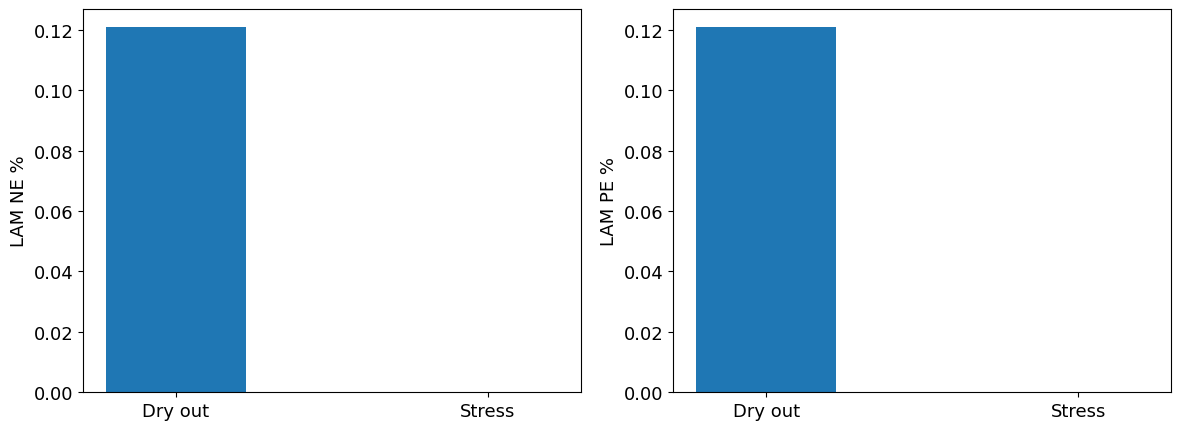

In [68]:
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True) 
width = 0.45
categories = ['Dry out', 'Stress',]
values_ne = [LAM_to_Dry_i,LAM_to_Crack_NE_i]
values_pe = [LAM_to_Dry_i,LAM_to_Crack_PE_i]
axs[0].bar(categories, values_ne, width )
axs[1].bar(categories, values_pe, width )
axs[0].set_ylabel("LAM NE %")
axs[1].set_ylabel("LAM PE %")

### Script from GEM to get the target figures:


In [69]:
# - LLI  due to SEI, SEI on crack, LiP and dry-out
case = Full_Exp2_GoodFit
LLI_to_SEI_allTs=[];        LLI_to_Dry_allTs =[]; 
LLI_to_SEIcr_allTs = [];    LLI_to_LiP_allTs =[]; 
fig, axs = plt.subplots(1,3, figsize=(15,4),tight_layout=True) 

fig, ax = plt.subplots(figsize=(8,4),tight_layout=True) 
X_labels = (
    r"10$^\circ$C",  #axs[i].set_title(f"T={T_deg}"+r"$^\circ$C")
    r"25$^\circ$C",
    r"40$^\circ$C",
)
LLI_Components = {
    "SEI":     np.array(LLI_to_SEI_allTs),
    "SEI on cracks":     np.array(LLI_to_SEIcr_allTs),
    "Li plating":     np.array(LLI_to_LiP_allTs),
    "LAM": np.array(LLI_to_Dry_allTs),
}
width = 0.45

bottom = np.zeros(3)
i=0
for key, weight_count in LLI_Components.items():
    p = ax.bar(X_labels, weight_count, width, label=key, bottom=bottom,color=Default_Colors_Alpha[i])
    bottom += weight_count
    i += 1

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("LLI %")
plt.savefig(
    target_folder + f"/Full LLI break down.png", dpi=800)
plt.savefig(
    target_folder + f"/Full LLI break down.svg")  

NameError: name 'Full_Exp2_GoodFit' is not defined

In [ ]:
# plot break down of LAM for Full 
# LAM - due to cracking; due to dry-out
case = Full_Exp2_GoodFit
LAM_to_Crack_NE_allTs=[];        LAM_to_Dry_allTs =[];  LAM_to_Crack_PE_allTs=[];  

for i,T_deg in enumerate([10,25,40]):
    LAM_to_Dry   = 100-np.array(case[str(T_deg)]['Width_all'])/case[str(T_deg)]['Width_all'][0]*100

    LAM_to_Dry_allTs.append(LAM_to_Dry[-1])
    LAM_to_Crack_NE_allTs.append(case[str(T_deg)]['CDend LAM_ne [%]'][-1]-LAM_to_Dry[-1])
    LAM_to_Crack_PE_allTs.append(case[str(T_deg)]['CDend LAM_pe [%]'][-1]-LAM_to_Dry[-1])
print(LAM_to_Crack_NE_allTs)
print(LAM_to_Crack_PE_allTs)
print(LAM_to_Dry_allTs)
LAM_NE_Components = {
    "Dry-out": np.array(LAM_to_Dry_allTs),
    "Stress":     np.array(LAM_to_Crack_NE_allTs),}
LAM_PE_Components = {
    "Dry-out": np.array(LAM_to_Dry_allTs),
    "Stress":     np.array(LAM_to_Crack_PE_allTs),}
Labels = ["LAM NE %","LAM PE %"]
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True) 
width = 0.45

LAM_Components_All = [LAM_NE_Components,LAM_PE_Components]
for k,LAM_Components in enumerate(LAM_Components_All):
    i=0;  bottom = np.zeros(3)
    for key, weight_count in LAM_Components.items():
        p = axs[k].bar(X_labels, weight_count, width, label=key, bottom=bottom,color=Default_Colors_Alpha[i])
        bottom += weight_count
        i += 1
    axs[k].set_ylim(0,12.5) # Labels
    axs[k].set_ylabel(Labels[k])
legend = axs[0].legend(loc='best',frameon=False)
plt.savefig(
    target_folder + f"/Full LAM break down.png", dpi=dpi)
plt.savefig(
    target_folder + f"/Full LAM break down.svg") 